# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

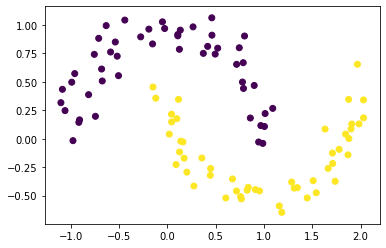

In [22]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
import operator
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)

## Задание

Напишите класс дерева, который реализует метод train, который получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо значения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [2]:
class Tree_element:
    def add_node(self, i, t, side):
        if type(self) is Leaf:
            raise ValueError('Attempt to add NODE to leaf')
        if self.subs[side] is not None:
            raise Exception('Element already had {0}-sided sub'.format(side))
        self.subs[side] = Node(i, t, self)
        
    def add_leaf(self, y_hat, side):
        if type(self) is Leaf:
            raise ValueError('Attempt to add LEAF to leaf')
        if self.subs[side] is not None:
            raise Exception('Element already had {0}-sided sub'.format(side))
        self.subs[side] = Leaf(y_hat, self)
        

In [3]:
class Root(Tree_element):
    def __init__(self, i, t):
        self.i = i
        self.t = t
        self.subs = {'l':None, 'r':None}
        self.depth = 0

class Node(Tree_element):
    def __init__(self, i, t, parent):
        self.i = i
        self.t = t
        self.subs = {'l':None, 'r':None}
        self.parent = parent
        self.depth = parent.depth + 1


class Leaf(Tree_element):
    def __init__(self, y_hat, parent):
        self.y_hat = y_hat
        self.parent = parent
        self.depth = parent.depth + 1
        

In [4]:
def calc_leaf_impurity(classes_count):
    _sum = 0
    for key in classes_count:
        _sum += classes_count[key]
    impurity = 1
    for key in classes_count:
        impurity -= (classes_count[key]/_sum)**2
    return impurity


In [5]:
def calc_node_impurity(r, l, count, index):
    right_count = count - index - 1
    left_count = count - right_count
    return (right_count/count)*r + (left_count/count)*l


In [6]:
def calc_gini(x, y):
    if len(x) == 1:
        return (0,0,0)
    ginis = [] #list of results (impurity, feature, threshold)
    classes = [] #collect all classes
    for yth in y:
        if yth not in classes:
            classes.append(yth)
    classes_count = {} #count instances classes
    for _class in classes:
        classes_count[_class] = 0            
    for feature_number in range(x.shape[1]): #for each feature
        uns = [] #unsorted list
        for item_index in range(x.shape[0]):
            uns.append((x[item_index,feature_number],y[item_index]))
        s = sorted(uns) #sorted by single feature
        s = np.array(s)
        for i in range(len(s) - 1): #for each threshold
            threshold = (s[i,0] + s[i+1,0])*.5
            for q in range(i+1): #calc left leaf ipmurity
                classes_count[s[q,1]] += 1
            l_leaf_impurity = calc_leaf_impurity(classes_count)
            for key in classes_count: #clear for second leaf
                classes_count[key] = 0
            for q in range(i+1,len(s)): #calc right leaf impurity
                classes_count[s[q,1]] += 1
            r_leaf_impurity = calc_leaf_impurity(classes_count)
            # added clearing
            for key in classes_count: #clear for second leaf
                classes_count[key] = 0
            # added clearing
            impurity = calc_node_impurity(r_leaf_impurity,l_leaf_impurity,x.shape[0],i)
            ginis.append((impurity, feature_number, threshold))
    gini = sorted(ginis)[0]
    return gini


In [7]:
def set_to_array(_set, front):
    _set = np.array(_set)
    x = _set[:,0:front]
    y = _set[:,front]
    return x, y


In [8]:
def divide_set(x, y, feature, threshold):
    tuple_list = []
    for i in range(len(x)):
        tuple_list.append(tuple(x[i])+(y[i],))
    s = sorted(tuple_list, key=lambda x :[feature])
    s = np.array(s)
    l_set, r_set = [], []
    for i in range(len(s)):
        if s[i,feature] < threshold:
            l_set.append(s[i])
        else:
            r_set.append(s[i])
    left = set_to_array(l_set, x.shape[1])
    right = set_to_array(r_set, x.shape[1])
    return left, right
        

In [9]:
def is_pure(y):
    classes = []
    for yth in y:
        if yth not in classes:
            classes.append(yth)
    if len(classes) > 1:
        return False
    else:
        return True


In [10]:
def find_dominant(y):
    classes_count = {}
    for yth in range(len(y)):
        if yth not in classes_count:
            classes_count[int(y[yth])] = 0
    for i in range(len(y)):
        classes_count[int(y[i])] += 1
    return max(classes_count.items(), key=operator.itemgetter(1))[0]


In [11]:
class Tree:    
    calc_gini = calc_gini
    def __init__(self, depth=1, max_num_leaf=None):
        self.is_trained = False
        self.depth = depth
        self.max_num_leaf = max_num_leaf
        self.root = None
        self.max_num_leaf = max_num_leaf
        self.logs = []
        
    def train(self, x, y, parent=None, side=None):
        _, feature, threshold = calc_gini(x, y)
        if parent is None:
#             if self.root is None:
#                 raise Exception('No parent PepeHands')
            self.root = Root(feature, threshold)
            print('root created')
            l, r = divide_set(x, y, feature, threshold)
            self.train(l[0], l[1], self.root,'l')
            self.train(r[0], r[1], self.root,'r')
        elif is_pure(y):
            parent.add_leaf(y[0], side)
            print('was pure at {0}'.format(parent.subs[side]))
        elif self.max_num_leaf is not None:
            if self.max_num_leaf > len(x) and parent.depth+1 < self.depth:
                parent.add_leaf(y[0], side)
            else:
                parent.add_node(feature, threshold, side)
                l, r = divide_set(x, y, feature, threshold)
                self.train(l[0], l[1], parent.subs[side],'l')
                self.train(r[0], r[1], parent.subs[side],'r')
        elif parent.depth+1 < self.depth:
            parent.add_node(feature, threshold, side)
            l, r = divide_set(x, y, feature, threshold)
            self.train(l[0], l[1], parent.subs[side],'l')
            self.train(r[0], r[1], parent.subs[side],'r')
        else:
            dominant = find_dominant(y)
            parent.add_leaf(dominant, side)
            self.logs.append((y.copy(), parent, parent.subs[side], side, dominant))
        self.is_trained = True
    
    def predict(self, x):
        if not self.is_trained:
            raise Exception('No train exception, have to train before predict, u dummy dumb dumb :)')
        y_hat = []
        print(len(x))
        for i in range(len(x)):
            elem = self.root
            while True:
                if x[i,elem.i] < elem.t:
                    if type(elem.subs['l']) is Leaf:
                        y_hat.append(elem.subs['l'].y_hat)
                        break
                    else:
                        elem = elem.subs['l']
                else:
                    if type(elem.subs['r']) is Leaf:
                        y_hat.append(elem.subs['r'].y_hat)
                        break
                    else:
                        elem = elem.subs['r']
        return np.array(y_hat)
    

# Решающее дерево

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

In [12]:
tree1 = Tree(1)
tree1.train(x,y)

root created
was pure at <__main__.Leaf object at 0x000001C5CB07C188>


49920


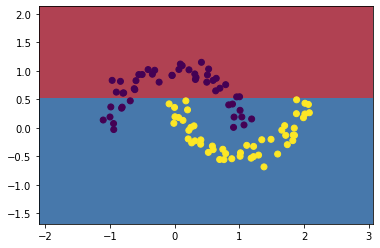

In [13]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree1.predict((np.stack((xx0.ravel(),xx1.ravel())).transpose()))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


In [14]:
tree2 = Tree(2)
tree2.train(x,y)

root created
was pure at <__main__.Leaf object at 0x000001C5CC0D9948>
was pure at <__main__.Leaf object at 0x000001C5CC0D9C48>


49920


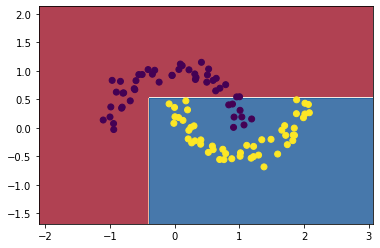

In [15]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree2.predict((np.stack((xx0.ravel(),xx1.ravel())).transpose()))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


In [23]:
tree3 = Tree(3)
tree3.train(x,y)

root created
was pure at <__main__.Leaf object at 0x000001C5CC1A4A08>
was pure at <__main__.Leaf object at 0x000001C5CC15CB48>
was pure at <__main__.Leaf object at 0x000001C5CC310388>
was pure at <__main__.Leaf object at 0x000001C5CC310C88>


47802


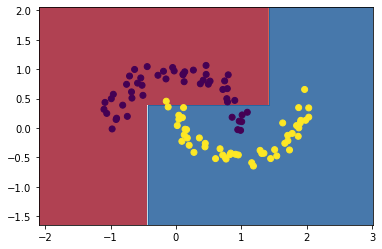

In [24]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree3.predict((np.stack((xx0.ravel(),xx1.ravel())).transpose()))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


root created
was pure at <__main__.Leaf object at 0x000001C5CC28FFC8>
was pure at <__main__.Leaf object at 0x000001C5CC28FF88>
was pure at <__main__.Leaf object at 0x000001C5CC28FF08>
was pure at <__main__.Leaf object at 0x000001C5CC28FE88>
was pure at <__main__.Leaf object at 0x000001C5CC28FE48>
was pure at <__main__.Leaf object at 0x000001C5CC28FDC8>
was pure at <__main__.Leaf object at 0x000001C5CC28FD88>
1884024


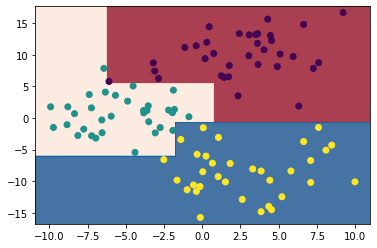

In [19]:
x, y = make_blobs(n_samples=100, cluster_std=3)

tree = Tree(100)
tree.train(x,y)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree.predict((np.stack((xx0.ravel(),xx1.ravel())).transpose()))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Постройте дерево максимальной глубины для своих случайных данных.